In [240]:
import sqlite3
import pandas as pd
conn = sqlite3.Connection("zillow.sqlite")
df = pd.read_csv('Data/zillow_data.csv')
#df.to_sql(name='zillow_df', con=conn)

In [241]:
def cutoff(df):
    ct = round(df.shape[0]*0.8)
    return ct
    
#def train_test(df):
    cutoff = round(df.shape[0]*0.8)
    train = df[:cutoff]
    test = df[cutoff:]
    return train, test

def acf_pacf(df):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    #Make ACF plot
    plot_acf(df, ax=ax1)
    #Make PACF plot
    plot_pacf(df, ax=ax2)
    plt.show();

In [242]:
def model_fit(df, train, pdq=(1,0,1)):
    model = SARIMAX(train, order=pdq)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return results

In [243]:
def train_RMSE(df, pdq=(1,0,1), display=True):
    model = SARIMAX(train, order=pdq)
    train_result = model.fit()
    train_pred = train_result.predict(typ='levels')
    rmse = np.sqrt(mse(df, train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show();

In [244]:
def model_fit(df, test, pdq=(1,0,1)):
    model = SARIMAX(test, order=pdq)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return results

In [245]:
def test_RMSE(df, pdq=(1,0,1), display=True):
    model = SARIMAX(df, order=pdq)
    test_result = model.fit()
    test_pred = test_result.predict(typ='levels')
    rmse = np.sqrt(mse(df, test_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        test[-60:].plot(label='Actual',color='b')
        test_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Test Data vs. Predicted Returns')
        plt.show();

In [246]:
def forecast_model(df, pdq=(1,0,1), pdqs=(0,0,0,1), display=True):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    predictions = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    prediction_confidence_interval = predictions.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        predictions.predicted_mean.plot(label='Forecast')
        ax.fill_between(prediction_confidence_interval.index,prediction_confidence_interval.iloc[:, 0],prediction_confidence_interval.iloc[:, 1], color='k', alpha=.25,label='Conf Interval')
        plt.title('Prediction of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show();
    year_1 = (1+predictions.predicted_mean[:12]).prod()-1
    year_3 = (1+predictions.predicted_mean[:36]).prod()-1
    year_5 = (1+predictions.predicted_mean[:60]).prod()-1
    year_10 = (1+predictions.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')


In [247]:
def forecast_model(df,pdq=(1,0,1),display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+predictions.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

In [248]:
q = """
SELECT *
FROM zillow_df
;
"""

pd.read_sql(q, conn)

,index,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,14721,93733,81225,Mount Crested Butte,CO,None,Gunnison,14722,191100.0,192400.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [250]:
print(df.SizeRank.describe(),'\n')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64 



In [252]:
sr_25 = df.SizeRank.quantile(q=0.25)
sr_25

3681.5

In [253]:
zc_top25 = df[df['SizeRank'] < sr_25].drop(['RegionID'], axis=1)
print(f'Amount of zipcodes: {len(zc_top25)}')

Amount of zipcodes: 3681


In [254]:
zc_top25

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,75110,Corsicana,TX,Corsicana,Navarro,3677,53700.0,53700.0,53700.0,53700.0,...,85900,86500,86900,87700,89300,91100,92000,92500,92700,92800
3677,95348,Merced,CA,Merced,Merced,3678,119200.0,117300.0,115600.0,114100.0,...,249400,250800,253300,256700,259300,261500,263900,266300,269500,272500
3678,90621,Buena Park,CA,Los Angeles-Long Beach-Anaheim,Orange,3679,157200.0,157100.0,157100.0,157200.0,...,541400,543900,548300,552400,555400,559000,564000,568500,572800,575000
3679,31093,Warner Robins,GA,Warner Robins,Houston,3680,56600.0,56800.0,57100.0,57400.0,...,60700,61500,62700,63300,63800,64900,66400,67500,68600,69400


In [255]:
zc_top25['yr_avg']=zc_top25.iloc[:,-12:].mean(skipna=True, axis=1)

In [256]:
print(zc_top25['yr_avg'].describe(),'\n')

count    3.681000e+03
mean     3.612590e+05
std      5.389645e+05
min      3.632500e+04
25%      1.640917e+05
50%      2.428333e+05
75%      3.946583e+05
max      1.858138e+07
Name: yr_avg, dtype: float64 



In [257]:
zc_top25 = zc_top25.drop(zc_top25.columns[6:150], axis=1)
zc_top25

,RegionName,City,State,Metro,CountyName,SizeRank,2008-04,2008-05,2008-06,2008-07,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg
0,60657,Chicago,IL,Chicago,Cook,1,865100.0,859000.0,851500.0,843800.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,1.014358e+06
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,211200.0,209500.0,207900.0,206700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,3.141667e+05
2,77494,Katy,TX,Houston,Harris,3,249500.0,248300.0,247800.0,247600.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,3.221750e+05
3,60614,Chicago,IL,Chicago,Cook,4,1144100.0,1135600.0,1125400.0,1113900.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,1.295967e+06
4,79936,El Paso,TX,El Paso,El Paso,5,128300.0,127300.0,126300.0,125400.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,1.200167e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3676,75110,Corsicana,TX,Corsicana,Navarro,3677,74000.0,73900.0,73600.0,73300.0,...,86500,86900,87700,89300,91100,92000,92500,92700,92800,8.890833e+04
3677,95348,Merced,CA,Merced,Merced,3678,192500.0,184900.0,178400.0,173100.0,...,250800,253300,256700,259300,261500,263900,266300,269500,272500,2.580250e+05
3678,90621,Buena Park,CA,Los Angeles-Long Beach-Anaheim,Orange,3679,461800.0,451600.0,442400.0,434600.0,...,543900,548300,552400,555400,559000,564000,568500,572800,575000,5.546250e+05
3679,31093,Warner Robins,GA,Warner Robins,Houston,3680,79100.0,78900.0,78400.0,77800.0,...,61500,62700,63300,63800,64900,66400,67500,68600,69400,6.424167e+04


In [258]:
#Calculate historical return on investment
zc_top25['ROI']= ((zc_top25['2018-04'] - zc_top25['2008-04'])/zc_top25['2008-04'])

#Calculate standard deviation of monthly values
zc_top25['std']=zc_top25.loc[:,'2008-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
zc_top25['mean']=zc_top25.loc[:,'2008-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
zc_top25['CV']=zc_top25['std']/zc_top25['mean']

#Show calculated values
zc_top25[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
0,60657,95448.656694,8.559331e+05,0.191307,0.111514
1,75070,41677.869365,2.368264e+05,0.523674,0.175985
2,77494,32712.079470,2.784645e+05,0.322244,0.117473
3,60614,128917.820077,1.101100e+06,0.142383,0.117081
4,79936,3574.889276,1.165091e+05,-0.053001,0.030683


In [259]:
#Descriptive statistics of coefficients of variance.
print(zc_top25.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = zc_top25.CV.quantile(.65)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best25 = zc_top25[zc_top25['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:25]
print('\n Best 5 Zipcodes:')

zc_best25

count    3681.000000
mean        0.138659
std         0.071520
min         0.011953
25%         0.080673
50%         0.129478
75%         0.184179
max         0.426992
Name: CV, dtype: float64

CV upper limit: 0.15934600898561407

 Best 5 Zipcodes:


,RegionName,City,State,Metro,CountyName,SizeRank,2008-04,2008-05,2008-06,2008-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
180,99301,Pasco,WA,Kennewick,Franklin,181,130400.0,130000.0,129900.0,129700.0,...,216000,217600,218300,218100,217600,211883.333333,0.668712,23394.532219,164642.975207,0.142093
602,76051,Grapevine,TX,Dallas-Fort Worth,Tarrant,603,215900.0,215300.0,214500.0,213900.0,...,334900,333900,336500,341400,344400,334258.333333,0.595183,40510.242710,254891.735537,0.158931
2362,78210,San Antonio,TX,San Antonio,Bexar,2363,75400.0,74700.0,74100.0,73500.0,...,110000,111900,114500,117200,119400,107516.666667,0.583554,11843.572027,75488.429752,0.156893
1211,76039,Euless,TX,Dallas-Fort Worth,Tarrant,1212,147200.0,147000.0,146700.0,146500.0,...,222600,226100,228400,229800,231000,219933.333333,0.569293,24661.088315,165685.123967,0.148843
1756,75028,Flower Mound,TX,Dallas-Fort Worth,Denton,1757,217900.0,217600.0,217600.0,217800.0,...,331900,332000,333700,337300,339600,328366.666667,0.558513,37204.961198,256142.975207,0.145251
2940,15217,Pittsburgh,PA,Pittsburgh,Allegheny,2941,201500.0,201800.0,202600.0,203500.0,...,303400,304900,307800,311700,314000,305800.000000,0.558313,34737.972650,235102.479339,0.147757
277,75035,Frisco,TX,Dallas-Fort Worth,Collin,278,235500.0,235200.0,235300.0,235500.0,...,362000,364700,366300,366600,366400,358841.666667,0.555839,43339.188442,273425.619835,0.158504
3072,2453,Waltham,MA,Boston,Middlesex,3073,392000.0,389900.0,387900.0,386000.0,...,596100,602800,608600,610600,609800,586408.333333,0.555612,69107.879804,435014.049587,0.158864
3575,78602,Bastrop,TX,Austin,Bastrop,3576,127200.0,127200.0,127500.0,127400.0,...,191700,191400,192000,194700,197500,190200.000000,0.552673,22035.437118,141096.694215,0.156173
335,76116,Fort Worth,TX,Dallas-Fort Worth,Tarrant,336,121100.0,121200.0,121300.0,121300.0,...,181900,183300,185000,186600,187800,178691.666667,0.550784,20932.925644,132061.983471,0.158508


In [261]:
graphing_best25 = zc_best25
zc_best25 = zc_best25.drop(['City','State','Metro', 'CountyName', 'SizeRank', 'yr_avg', 'ROI', 'std', 'mean', 'CV'],axis=1)
zc_best25

KeyError: "['City' 'State' 'Metro' 'CountyName' 'SizeRank' 'yr_avg' 'ROI' 'std'\n 'mean' 'CV'] not found in axis"

## Diverging from Greg's Original Method

In [216]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [217]:
ts_best25 = melt_data(zc_best25).set_index('time')
ts_best25.to_csv('best25.csv')

In [218]:
dfs_ts = []
for zc in ts_best25.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    new_df = ts_best25[ts_best25['RegionName']==zc].asfreq('MS')
    dfs_ts.append(new_df)

In [219]:
print('Time series data for the 25 zipcodes:\n',ts_best25.head(25))

Time series data for the 25 zipcodes:
             RegionName     value
time                            
2008-04-01       99301  130400.0
2008-04-01       76051  215900.0
2008-04-01       78210   75400.0
2008-04-01       76039  147200.0
2008-04-01       75028  217900.0
2008-04-01       15217  201500.0
2008-04-01       75035  235500.0
2008-04-01        2453  392000.0
2008-04-01       78602  127200.0
2008-04-01       76116  121100.0
2008-04-01       76021  166900.0
2008-04-01       75019  268900.0
2008-04-01       76040  142600.0
2008-04-01       43221  226100.0
2008-04-01       77840  138000.0
2008-04-01       78748  187400.0
2008-04-01       78626  157000.0
2008-04-01       37129  155700.0
2008-04-01       43214  199500.0
2008-04-01       80910  137500.0
2008-04-01       70663  102400.0
2008-04-01       78728  178300.0
2008-04-01       75287  224400.0
2008-04-01       58078  163300.0
2008-04-01       76108  110100.0


In [220]:
import matplotlib.pyplot as plt
%matplotlib inline

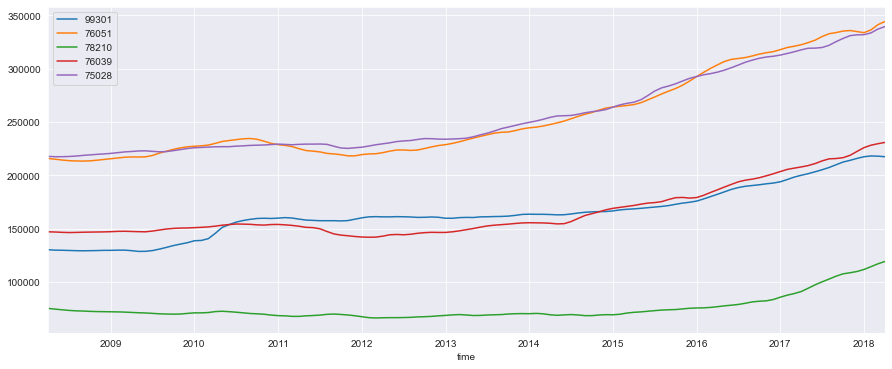

In [221]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0],figsize=(15,6))
    plt.legend();

In [222]:
import numpy as np

In [223]:
import numpy as np
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['monthly_return']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['monthly_return'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1        

/var/folders/vy/49_tcw8x7j3_jxs3gwg4y6v00000gn/T/ipykernel_3534/4122279489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_ts[zc]['monthly_return'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1


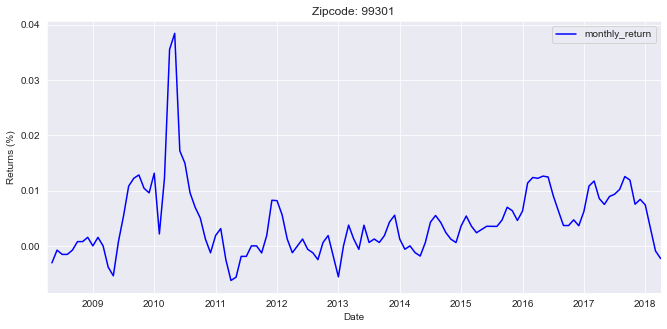

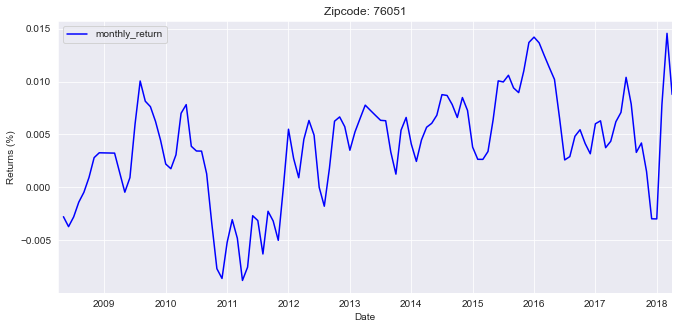

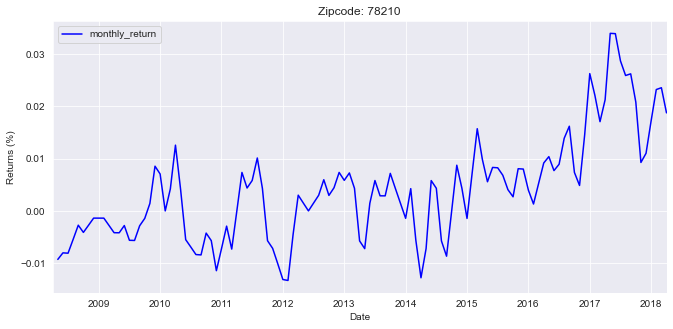

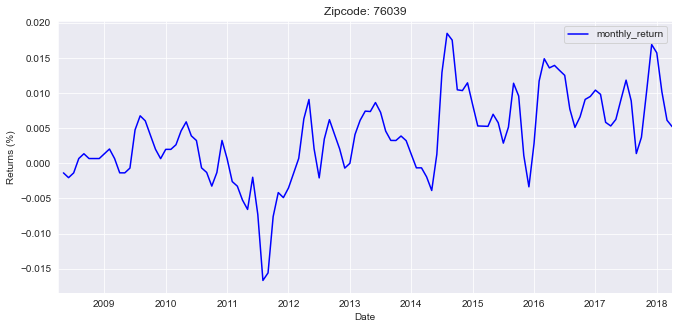

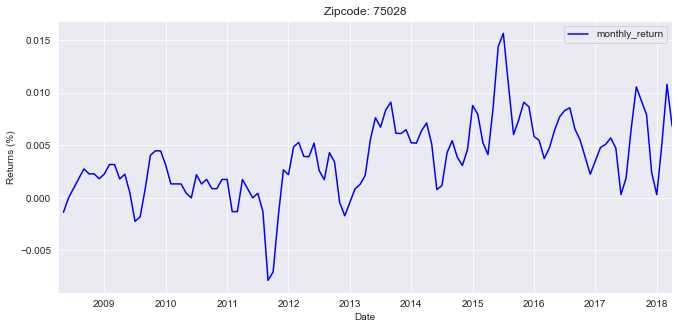

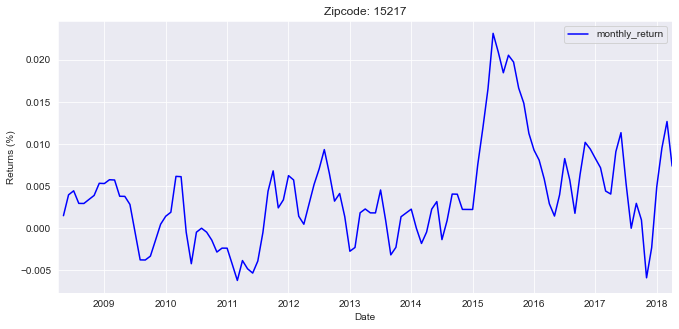

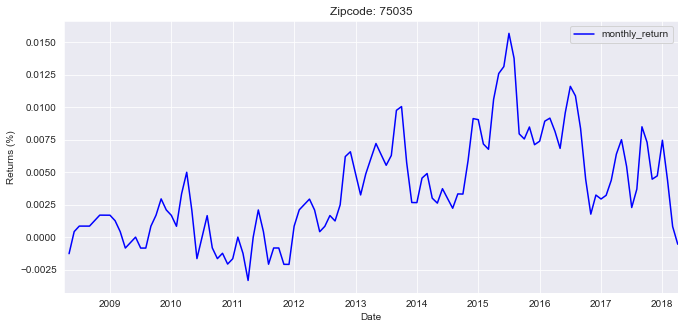

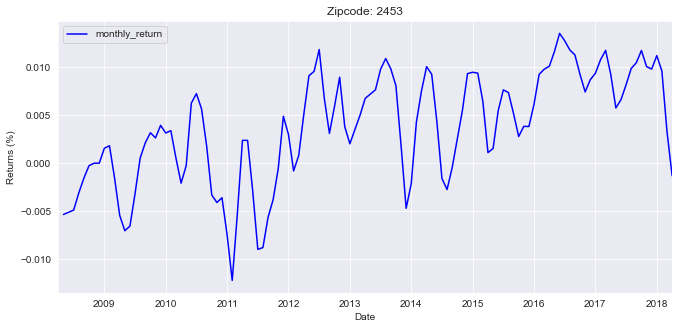

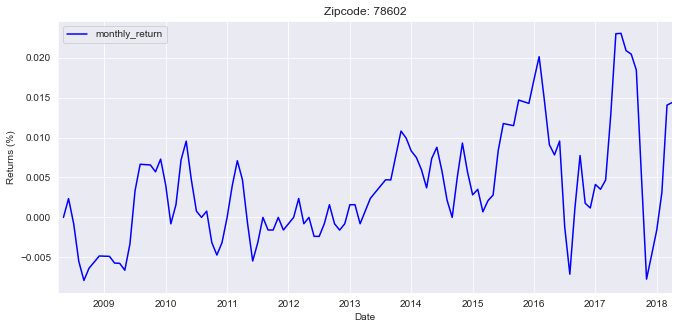

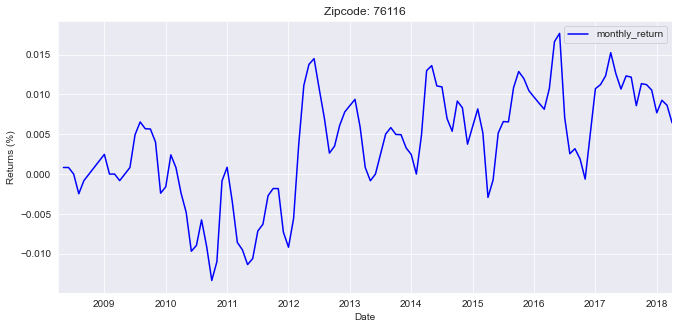

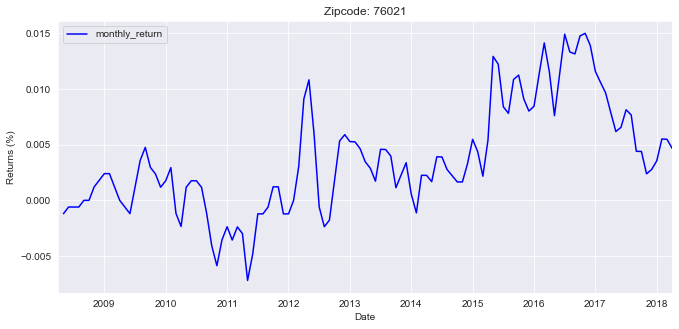

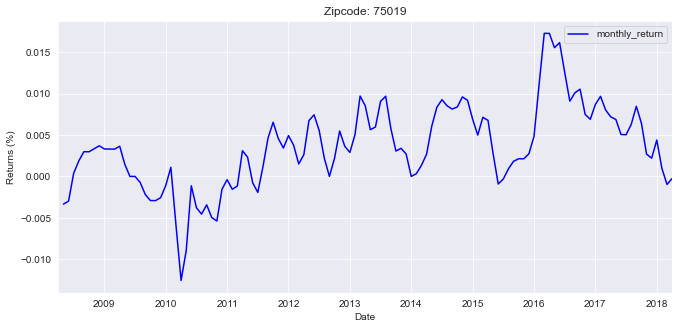

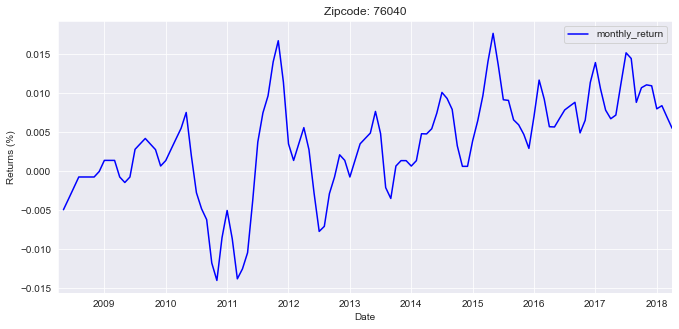

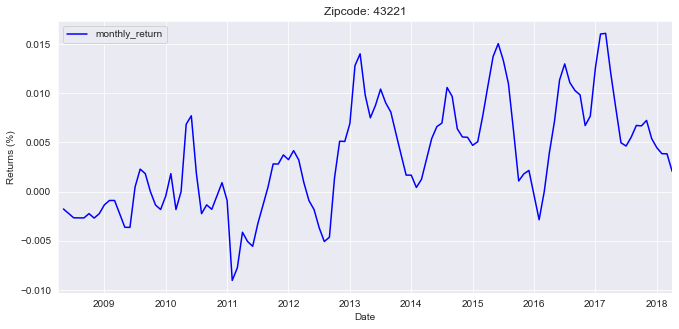

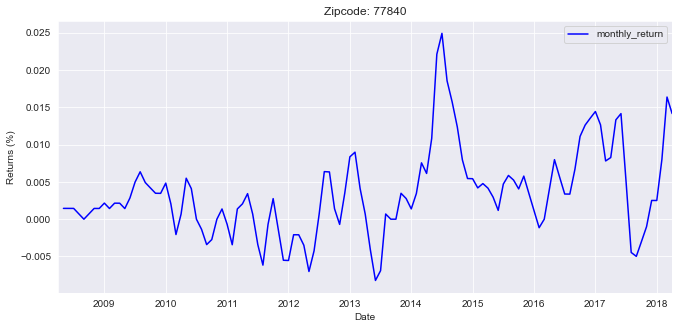

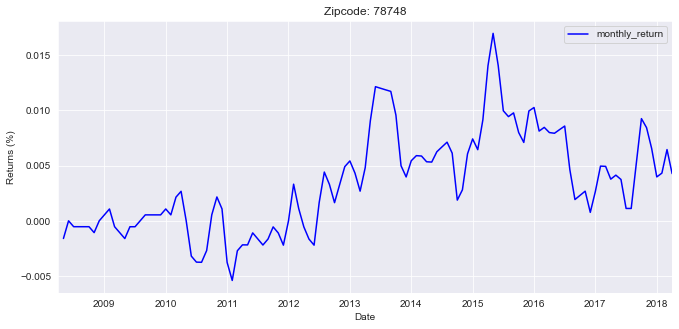

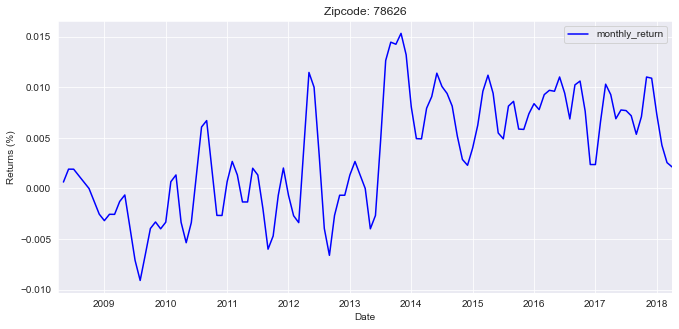

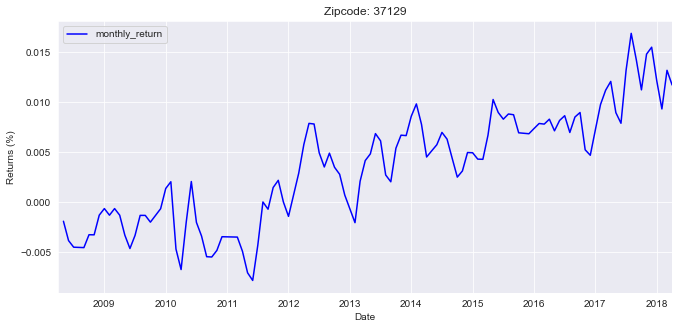

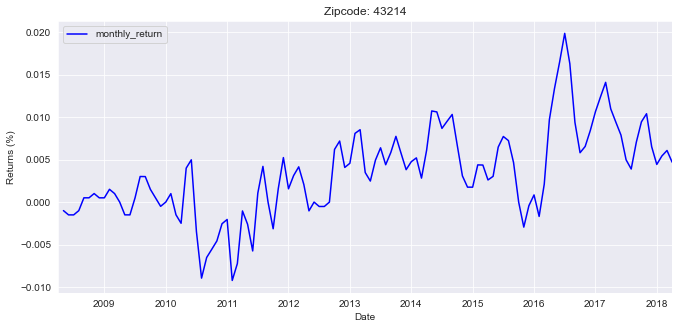

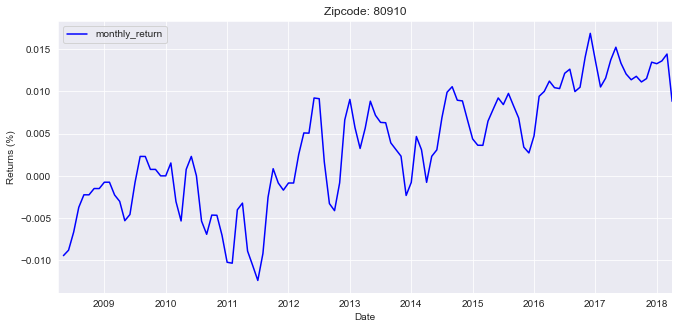

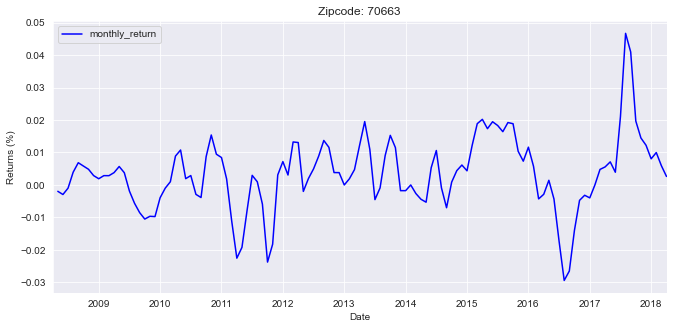

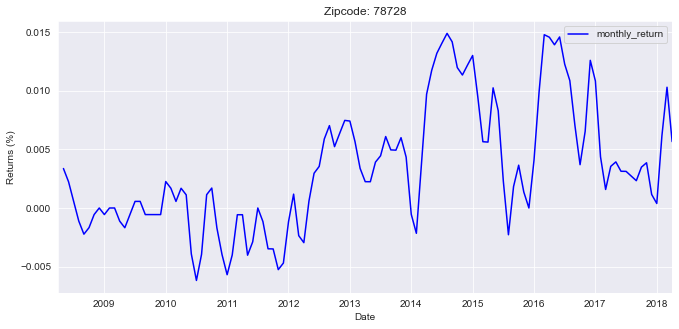

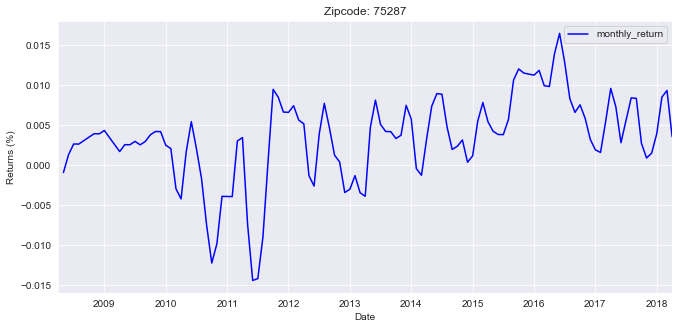

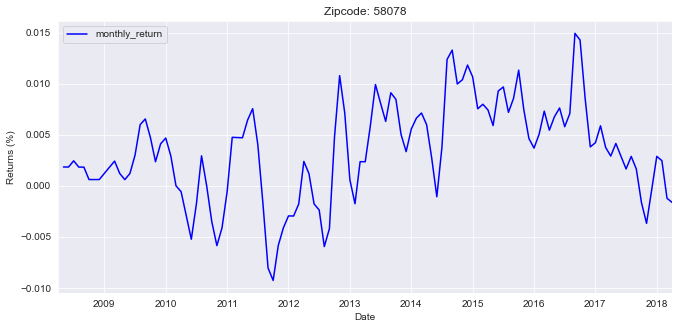

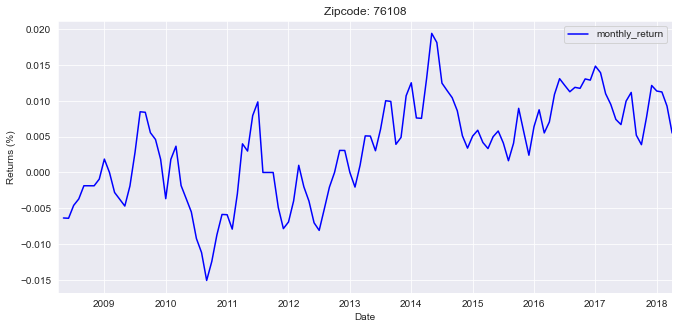

In [224]:
#Plot the monthly returns of each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].monthly_return.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

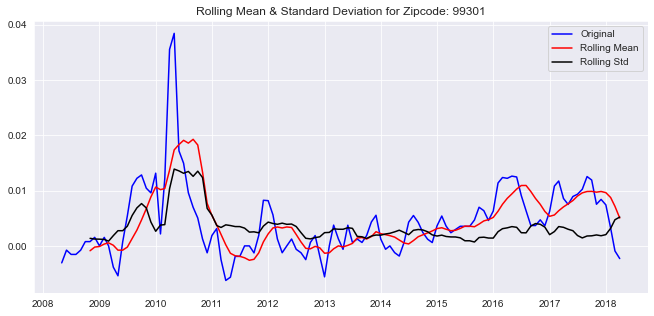

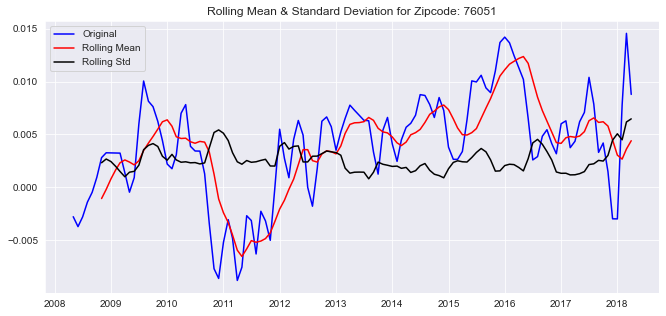

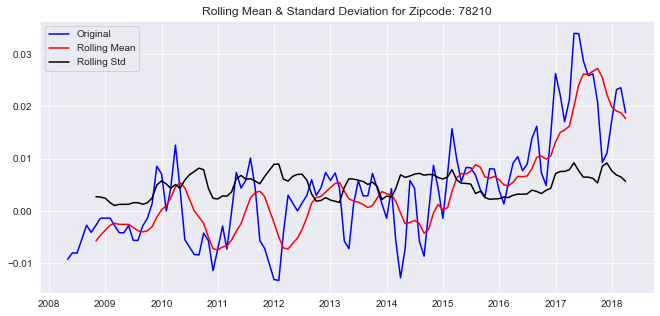

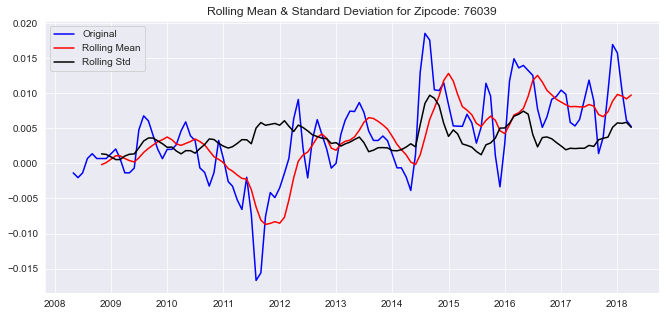

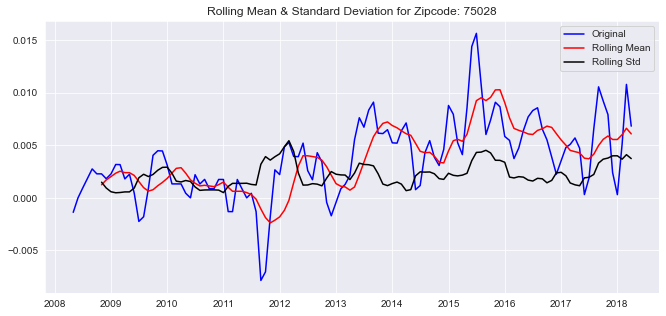

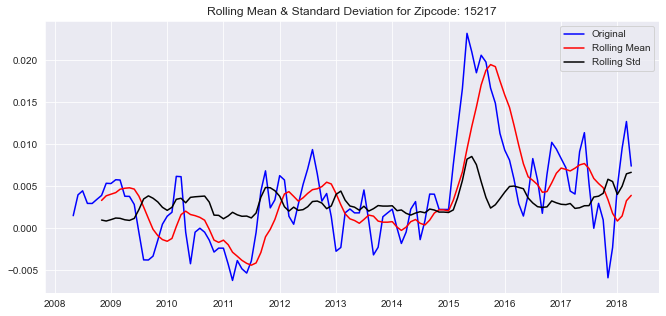

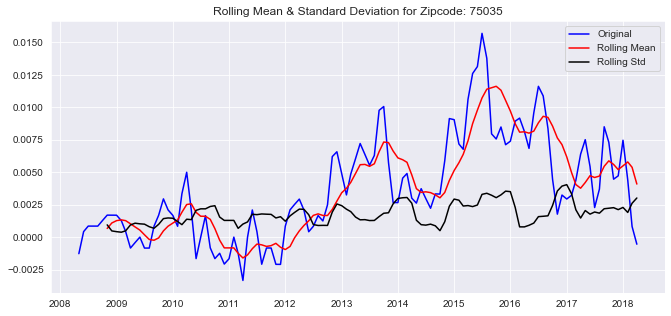

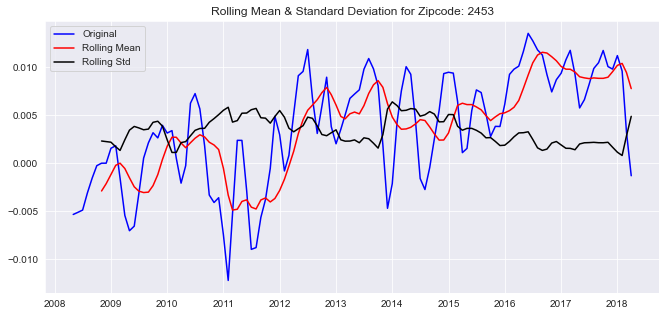

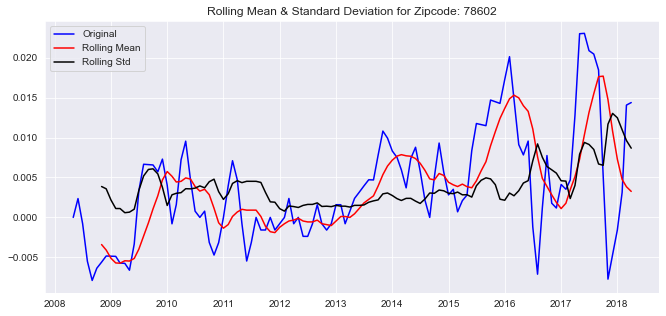

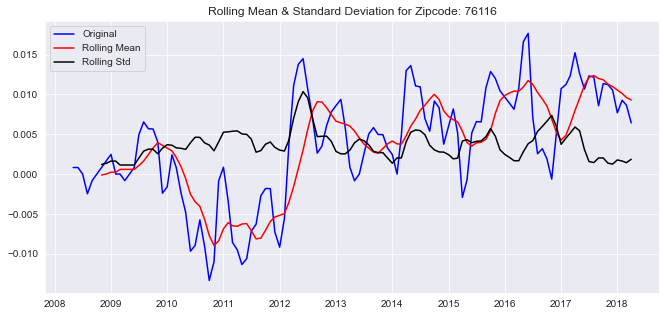

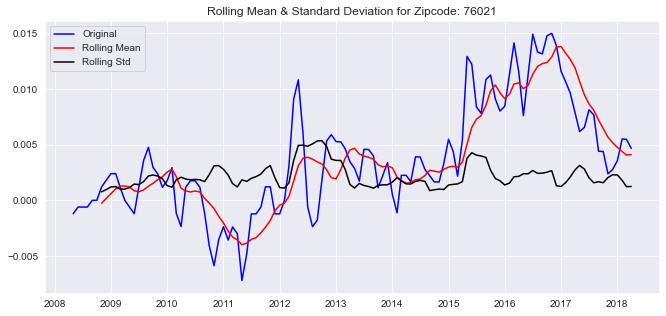

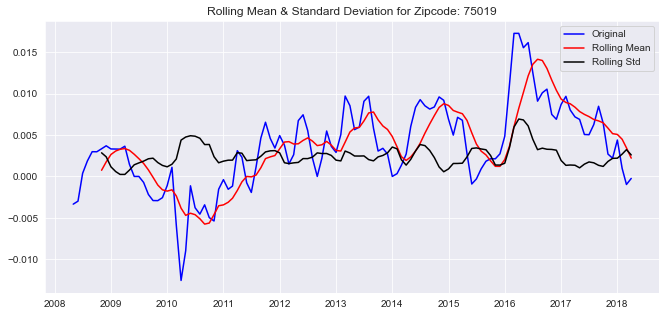

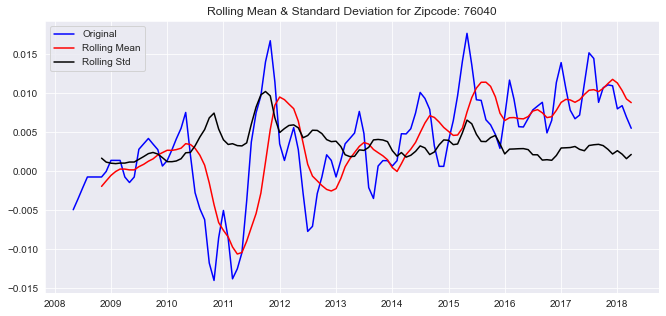

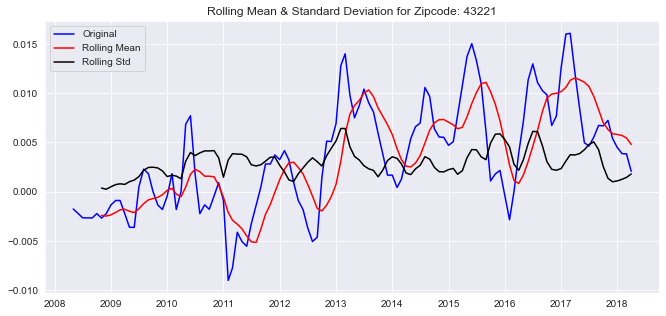

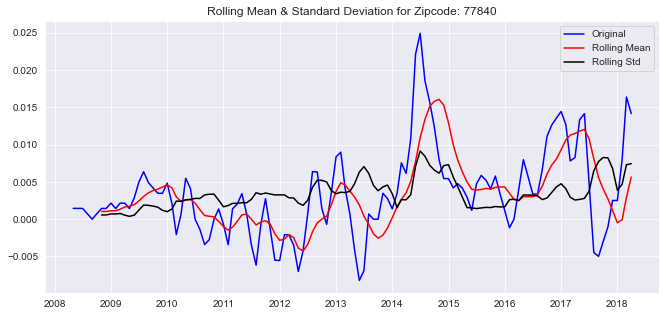

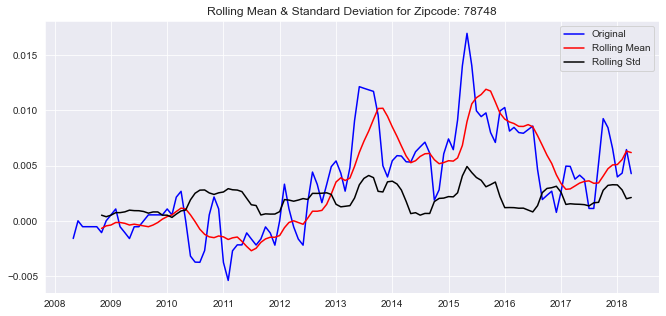

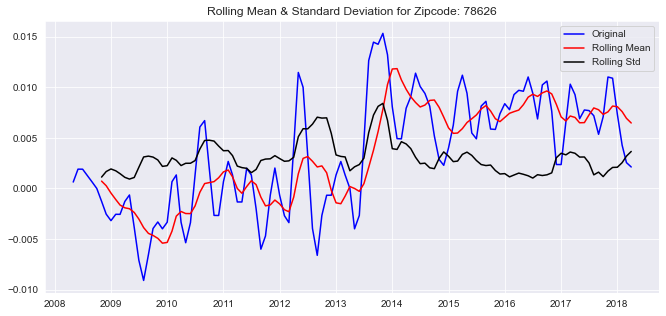

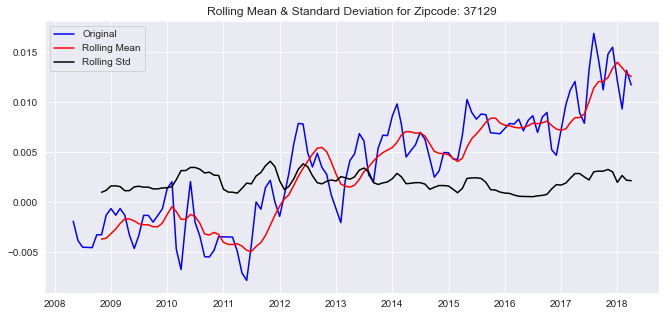

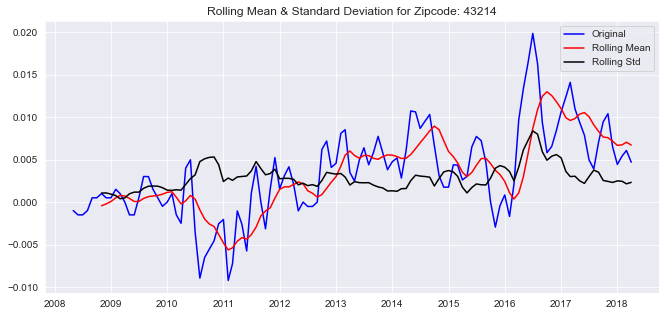

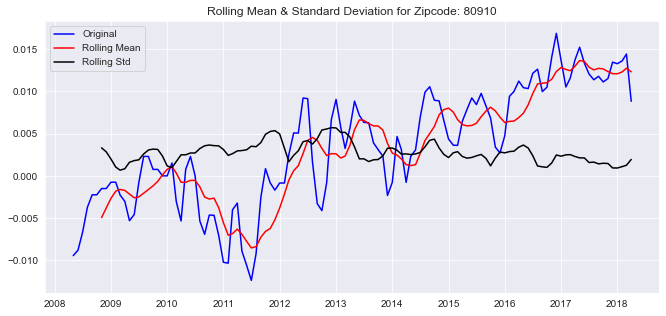

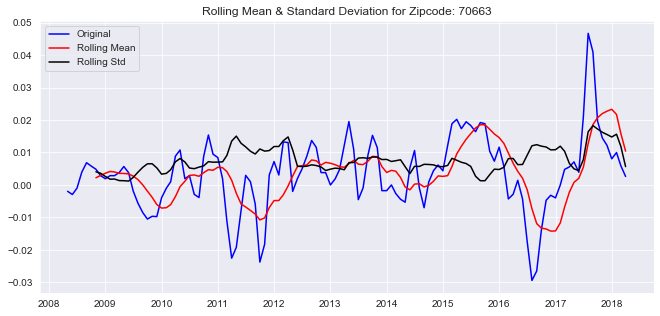

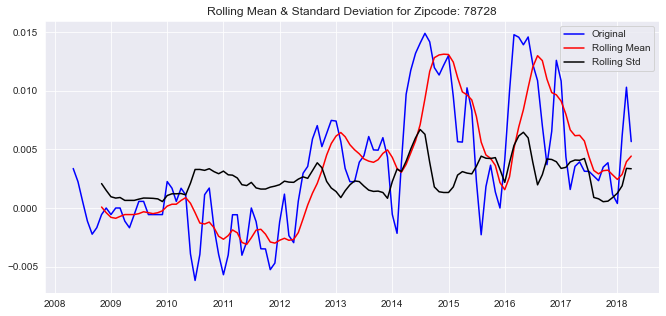

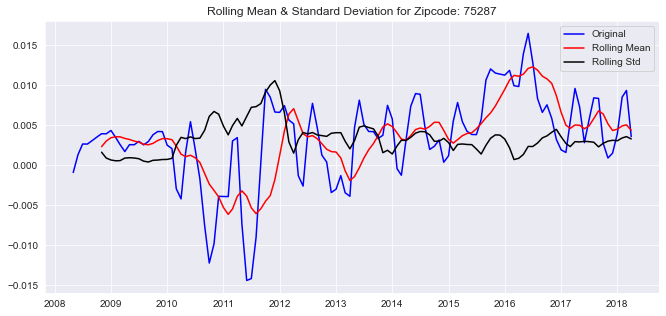

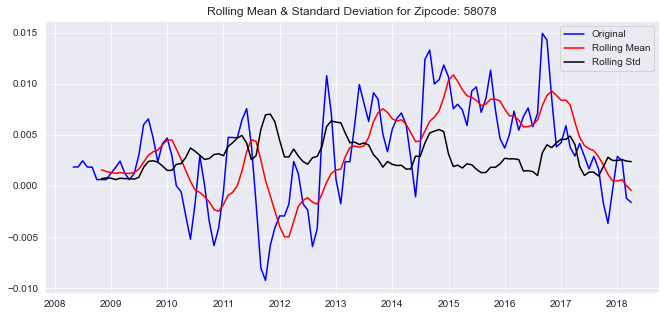

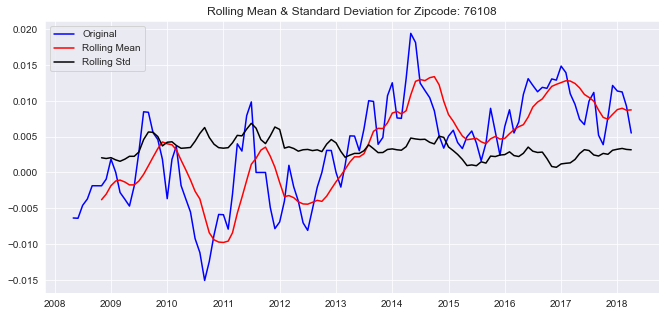

In [225]:
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].monthly_return.rolling(window = 7, center = False).mean()
    rolstd = dfs_ts[i].monthly_return.rolling(window = 7, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].monthly_return, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [226]:
from statsmodels.tsa.stattools import adfuller

In [227]:
to_be_diff = []
for i in range(25):
    results = adfuller(dfs_ts[i].monthly_return.dropna())
    dfs_ts[i].monthly_return.dropna(inplace = True)
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
        to_be_diff.append(i)
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 99301
p-value: 0.044745366240098124
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 76051
p-value: 0.03861141471278917
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 78210
p-value: 0.7572691938712955
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 76039
p-value: 0.10161131018324215
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 75028
p-value: 0.7111859983981901
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 15217
p-value: 0.2961592115080528
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 75035
p-value: 0.5213150431217702
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 2453
p-value: 0.12685375785466807
Fail to reject the null hypothesis. Data 

In [228]:
to_be_diff

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24]

In [229]:
for i in to_be_diff:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(dfs_ts[i].monthly_return.diff().dropna())
    dfs_ts[i].monthly_return.diff().dropna(inplace = True)
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 78210
p-value: 3.1363332223832726e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 76039
p-value: 6.066468801494346e-23
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 75028
p-value: 1.1970150421623025e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 15217
p-value: 0.0019171974003235979
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 75035
p-value: 0.017009580754013216
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 2453
p-value: 5.233513924523785e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 78602
p-value: 1.0204174022148014e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 76116
p-value: 9.440055578469247e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipco

In [230]:
len(dfs_ts)

25

In [231]:
zipcode_list = []
for z in range(25):
    zipcode_list.append(dfs_ts[z].RegionName[0])
zipcode_list

[99301,
 76051,
 78210,
 76039,
 75028,
 15217,
 75035,
 2453,
 78602,
 76116,
 76021,
 75019,
 76040,
 43221,
 77840,
 78748,
 78626,
 37129,
 43214,
 80910,
 70663,
 78728,
 75287,
 58078,
 76108]

In [232]:
dfs_ts

[            RegionName     value  monthly_return
 time                                            
 2008-04-01       99301  130400.0             NaN
 2008-05-01       99301  130000.0       -0.003067
 2008-06-01       99301  129900.0       -0.000769
 2008-07-01       99301  129700.0       -0.001540
 2008-08-01       99301  129500.0       -0.001542
 ...                ...       ...             ...
 2017-12-01       99301  216000.0        0.008403
 2018-01-01       99301  217600.0        0.007407
 2018-02-01       99301  218300.0        0.003217
 2018-03-01       99301  218100.0       -0.000916
 2018-04-01       99301  217600.0       -0.002293
 
 [121 rows x 3 columns],
             RegionName     value  monthly_return
 time                                            
 2008-04-01       76051  215900.0             NaN
 2008-05-01       76051  215300.0       -0.002779
 2008-06-01       76051  214500.0       -0.003716
 2008-07-01       76051  213900.0       -0.002797
 2008-08-01       76051

In [233]:
final_ts = []
for z in range(len(zipcode_list)):
    final_ts.append(dfs_ts[z].monthly_return.dropna())
    

In [234]:
final_ts

[time
 2008-05-01   -0.003067
 2008-06-01   -0.000769
 2008-07-01   -0.001540
 2008-08-01   -0.001542
 2008-09-01   -0.000772
                 ...   
 2017-12-01    0.008403
 2018-01-01    0.007407
 2018-02-01    0.003217
 2018-03-01   -0.000916
 2018-04-01   -0.002293
 Freq: MS, Name: monthly_return, Length: 120, dtype: float64,
 time
 2008-05-01   -0.002779
 2008-06-01   -0.003716
 2008-07-01   -0.002797
 2008-08-01   -0.001403
 2008-09-01   -0.000468
                 ...   
 2017-12-01   -0.002977
 2018-01-01   -0.002986
 2018-02-01    0.007787
 2018-03-01    0.014562
 2018-04-01    0.008787
 Freq: MS, Name: monthly_return, Length: 120, dtype: float64,
 time
 2008-05-01   -0.009284
 2008-06-01   -0.008032
 2008-07-01   -0.008097
 2008-08-01   -0.005442
 2008-09-01   -0.002736
                 ...   
 2017-12-01    0.011029
 2018-01-01    0.017273
 2018-02-01    0.023235
 2018-03-01    0.023581
 2018-04-01    0.018771
 Freq: MS, Name: monthly_return, Length: 120, dtype: float64,
 tim

## Graphs on the Top 25

In [235]:
ts_best25

,RegionName,value
time,,
2008-04-01,99301,130400.0
2008-04-01,76051,215900.0
2008-04-01,78210,75400.0
2008-04-01,76039,147200.0
2008-04-01,75028,217900.0
...,...,...
2018-04-01,70663,153100.0
2018-04-01,78728,266500.0
2018-04-01,75287,335100.0


array([[<AxesSubplot:title={'center':'RegionName'}>,
        <AxesSubplot:title={'center':'value'}>]], dtype=object)

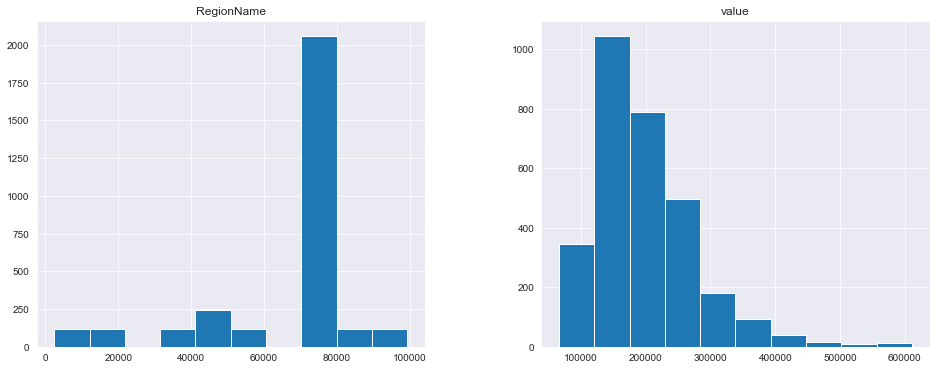

In [236]:
import matplotlib.pyplot as plt
ts_best25.hist(figsize=(16,6),)

<AxesSubplot:xlabel='time'>

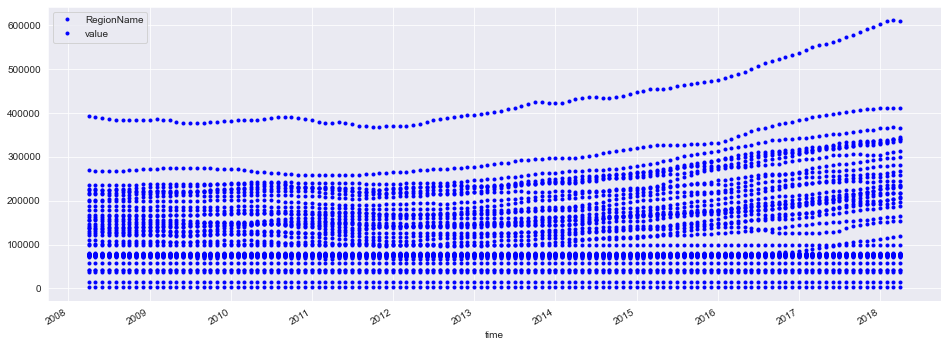

In [237]:
ts_best25.plot(figsize=(16,6), style='b.')

In [238]:
year_groups = ts_best25.groupby(pd.Grouper(freq = 'A'))
year_groups

In [239]:
ts_best25_annual = pd.DataFrame()
for year, group in year_groups:
    ts_best25_annual[yr.year] = group.values.ravel()
ts_best25_annual.plot(figsize = (22,15), subplots = True, legend = True)
plt.show()

NameError: name 'yr' is not defined

In [ ]:
ts_best25['value'].plot(kind='kde', figsize = (22,6), legend = True)
plt.show();

In [ ]:
graphing_best25

In [ ]:
import seaborn as sns
# df.loc[(df[‘Color’] == ‘Green’) | (df[‘Shape’] == ‘Rectangle’)]

x= graphing_best25['RegionName'] == '78626'
y= graphing_best25['ROI']
fig, ax = plt.subplots(figsize=(20,12))
sns.set_style("darkgrid")
ax = sns.barplot(x, y, palette='mako')
ax.set_xlabel('Zip Code', fontsize=20)
ax.set_ylabel('Percentage', color='black', fontsize=20)
ax.set_title('ROI for Top 5 Zipcodes', fontsize=20)

In [ ]:
# ts_99301 = dfs_ts[0].monthly_return.dropna()
# ts_76051 = dfs_ts[1].monthly_return.dropna()
# ts_78210 = dfs_ts[2].monthly_return.diff().dropna()
# ts_76039 = dfs_ts[3].monthly_return.diff().dropna()
# ts_75028 = dfs_ts[4].monthly_return.diff().dropna()

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
type(results)

In [ ]:
results

In [ ]:
for i in range(len(final_ts)):
    ct = cutoff(final_ts[i])
    train = final_ts[i][:ct]
    test = final_ts[i][ct:]
    
    results = pm.auto_arima(train,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=False,error_action='ignore',suppress_warnings=True)
    print(f'For zipcode {zipcode_list[i]}, the best parameters are: {results}')
    # model_fit(train, test, pdq=(1,0,1))


In [ ]:
def aa_results(zipcode, df):
    for i in range(len(zipcode)):
        results = pm.auto_arima(df[i].RegionName[0],information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
    return results

## 99301

In [ ]:
ct = cutoff(ts_99301)
ct

In [ ]:
cutoff(ts_75028)

In [ ]:
train_99301 = ts_99301[:ct]
test_99301 = ts_99301[ct:]

In [ ]:
train_99301

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_99301, label='train')
ax.plot(test_99301, label='test')
ax.set_title('Train-Test Split');
plt.legend()
plt.show();

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
acf_pacf(ts_99301)

In [ ]:
results_99301 = pm.auto_arima(ts_99301,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results_99301

In [ ]:
model_fit(train_99301, ts_99301[:ct], pdq=(1,0,1))

In [ ]:
train_RMSE(train_99301, pdq=(1,0,1))

In [ ]:
model_fit(test_99301, ts_99301[ct:], pdq=(1,0,1))

In [ ]:
test_RMSE(test_99301, pdq=(1,0,1))

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
forecast_model(ts_99301, pdq=(1,0,1), zc=99301)

## 76051

In [ ]:
cutoff(ts_76051)

In [ ]:
train_76051 = ts_76051[:ct]
test_76051 = ts_76051[ct:]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_76051, label='train')
ax.plot(test_76051, label='test')
ax.set_title('Train-Test Split');
plt.legend()
plt.show();

In [ ]:
acf_pacf(ts_76051)

In [ ]:
results_76051 = pm.auto_arima(ts_76051,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results_76051

In [ ]:
model_fit(train_76051, ts_76051[:ct], pdq=(1,0,1))

In [ ]:
train_RMSE(train_76051, pdq=(1,0,1))

In [ ]:
model_fit(test_76051, ts_76051[ct:], pdq=(1,0,1),pdqs=(2,0,1,12))

In [ ]:
test_RMSE(test_76051, pdq=(1,0,1))

In [ ]:
forecast_model(ts_76051, pdq=(1,0,1),zc=76051)

## 78210

In [ ]:
cutoff(ts_78210)

In [ ]:
train_78210 = ts_78210[:ct]
test_78210 = ts_78210[ct:]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_78210, label='train')
ax.plot(test_78210, label='test')
ax.set_title('Train-Test Split');
plt.legend()
plt.show();

In [ ]:
acf_pacf(ts_78210)

In [ ]:
results_78210 = pm.auto_arima(ts_78210,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results_78210

In [ ]:
model_fit(train_78210, ts_78210[:ct], pdq=(3,0,0))

In [ ]:
train_RMSE(train_78210, pdq=(3,0,0))

In [ ]:
model_fit(test_78210, ts_78210[ct:], pdq=(3,0,0), pdqs=(2,0,0,12))

In [ ]:
test_RMSE(test_78210, pdq=(3,0,0))

In [ ]:
forecast_model(ts_78210, pdq=(3,0,0),zc=78210)

## 76039

In [ ]:
cutoff(ts_76039)

In [ ]:
train_76039 = ts_76039[:ct]
test_76039 = ts_76039[ct:]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_76039, label='train')
ax.plot(test_76039, label='test')
ax.set_title('Train-Test Split');
plt.legend()
plt.show();

In [ ]:
acf_pacf(ts_76039)

In [ ]:
results_76039 = pm.auto_arima(ts_76039,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results_76039

In [ ]:
model_fit(train_76039, ts_76039[:ct], pdq=(0,0,1))

In [ ]:
train_RMSE(train_76039, pdq=(0,0,1))

In [ ]:
model_fit(test_76039, ts_76039[ct:], pdq=(0,0,1))

In [ ]:
test_RMSE(test_76039, pdq=(0,0,1))

In [ ]:
forecast_model(ts_76039, pdq=(0,0,1),zc=76039)

## 75028

In [ ]:
cutoff(ts_75028)

In [ ]:
train_75028 = ts_75028[:ct]
test_75028 = ts_75028[ct:]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_75028, label='train')
ax.plot(test_75028, label='test')
ax.set_title('Train-Test Split');
plt.legend()
plt.show();

In [ ]:
acf_pacf(ts_75028)

In [ ]:
results_75028 = pm.auto_arima(ts_75028,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results_75028

In [ ]:
model_fit(train_75028, ts_75028[:ct], pdq=(1,0,3))

In [ ]:
train_RMSE(train_75028, pdq=(1,0,3))

In [ ]:
model_fit(test_75028, ts_75028[ct:], pdq=(1,0,3),pdqs=(0,0,2,12))

In [ ]:
test_RMSE(test_75028, pdq=(1,0,3))

In [ ]:
forecast_model(ts_75028, pdq=(1,0,3),zc=75028)